In [480]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/hipparcos-star-catalog/hipparcos-voidmain.csv


# Setup

In [481]:
data = pd.read_csv('/kaggle/input/hipparcos-star-catalog/hipparcos-voidmain.csv')
length = len(data)
pal7 = sns.color_palette("Spectral", 7)[::-1] # inverted spectral palette with 7 colours, one for each star type
SEED = 123

# EDA

In [482]:
# Check null values in original data
nan_df = pd.DataFrame(data.isna().sum())
nan_df.reset_index(inplace = True)
nan_df.columns = ['Column', '# Null']
nan_df['% Null'] = 100 * nan_df['# Null'] / length
nan_df.sort_values('% Null', ascending = False, inplace = True)
display(nan_df.head(5))

,Column,# Null,% Null
51,Period,115677,97.850581
60,Source,114982,97.262684
54,morePhoto,114637,96.970850
70,Notes,114040,96.465851
53,moreVar,109964,93.017984


In [483]:
# Info
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118218 entries, 0 to 118217
Data columns (total 78 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Catalog    118218 non-null  object 
 1   HIP        118218 non-null  int64  
 2   Proxy      10925 non-null   object 
 3   RAhms      118218 non-null  object 
 4   DEdms      118218 non-null  object 
 5   Vmag       118217 non-null  float64
 6   VarFlag    11562 non-null   float64
 7   r_Vmag     118217 non-null  object 
 8   RAdeg      117955 non-null  float64
 9   DEdeg      117955 non-null  float64
 10  AstroRef   13734 non-null   object 
 11  Plx        117955 non-null  float64
 12  pmRA       117955 non-null  float64
 13  pmDE       117955 non-null  float64
 14  e_RAdeg    117955 non-null  float64
 15  e_DEdeg    117955 non-null  float64
 16  e_Plx      117955 non-null  float64
 17  e_pmRA     117955 non-null  float64
 18  e_pmDE     117955 non-null  float64
 19  DE:RA      117955 non-n

None

In [484]:
data.describe()

,HIP,Vmag,VarFlag,RAdeg,DEdeg,Plx,pmRA,pmDE,e_RAdeg,e_DEdeg,...,moreVar,Nsys,Ncomp,theta,rho,e_rho,dHp,e_dHp,HD,(V-I)red
count,118218.000000,118217.000000,11562.000000,117955.000000,117955.000000,117955.000000,117955.000000,117955.000000,117955.000000,117955.00000,...,8254.000000,19393.000000,117955.000000,11101.000000,11101.000000,11101.000000,11101.000000,11101.000000,98880.000000,118218.000000
mean,59176.745707,8.373233,1.739405,181.466380,-2.143250,7.215220,-1.303405,-16.599682,1.320787,1.10227,...,1.671432,1.193162,1.096452,181.245113,2.404513,0.019035,1.720967,0.160373,114374.227569,0.758321
std,34169.725917,1.312044,0.618728,103.261685,41.016397,11.286095,98.199404,93.859400,4.123088,3.43051,...,0.469721,0.418750,0.299403,104.910916,3.316871,0.021216,1.170635,0.252330,74189.731163,0.581249
min,1.000000,-1.440000,1.000000,0.000912,-89.782454,-54.950000,-4410.790000,-5813.000000,0.270000,0.33000,...,1.000000,1.000000,1.000000,0.000000,0.082000,0.001000,0.000000,0.010000,1.000000,-0.520000
25%,29581.250000,7.640000,1.000000,93.425334,-36.636503,2.510000,-15.150000,-21.740000,0.670000,0.59000,...,1.000000,1.000000,1.000000,92.000000,0.352000,0.005000,0.650000,0.030000,46735.750000,0.410000
50%,59177.500000,8.440000,2.000000,181.969874,-1.945926,4.610000,-1.680000,-5.650000,0.870000,0.72000,...,2.000000,1.000000,1.000000,183.000000,0.978000,0.011000,1.630000,0.070000,110373.500000,0.690000
75%,88767.750000,9.150000,2.000000,271.744455,31.435615,8.410000,11.840000,3.760000,1.170000,0.92000,...,2.000000,1.000000,1.000000,272.000000,3.050000,0.025000,2.700000,0.180000,175840.250000,1.040000
max,120416.000000,14.080000,3.000000,359.978792,89.569409,772.330000,6767.260000,10326.930000,281.160000,241.06000,...,2.000000,4.000000,4.000000,359.000000,23.588000,0.242000,4.470000,5.620000,358431.000000,9.290000


### Spectral Types

In [485]:
# Organising data
df = data[['Hpmag','B-V','SpType','Plx','RAdeg','DEdeg','pmRA','pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE', 'F1', 'F2']]
df.dropna(inplace=True)

## Organise spectral types. The dataset has 4070 unique spectral types, but we'll separate them into the 7 familiar ones: O, B, A, F, G, K, M.

### Check which stars do not start with O, B, A, F, G, K, M: only 0.4%, let's discard those
sp_types = ['O','B','A','F','G','K','M']
print("Percentage of stars with peculiar classification:", 100* len(df[~df['SpType'].str[0].isin(sp_types)]) / length, "%")

### Update dataframe to only include relevant sp types
df = df[df['SpType'].str[0].isin(sp_types)]
df['SpType Simple'] = df['SpType'].str[0] # letter only
df['SpType'] = df['SpType'].str[:2] # letter and number

Percentage of stars with peculiar classification: 0.3975705899270839 %


### Distance, magnitude, temperature

In [486]:
# To get the magnitude as a function of temperature, we first need to get the temperature
# We can use Ballesteros' formula to connect the B-V colour of the star to its temperature.
# Ballesteros' formula = some clever approximations with the Planck equation to get temperature as a function of two intensities on a blackbody curve.

# Get distance (pc)
df['dist_pc'] = 1/df['Plx']

# Get magnitude
m = data['Hpmag'] # apparent magnitude
df['M'] = 5 * np.log10(df['dist_pc'] / 10) - m # absolute magnitude 
# A very small portion of values of the absolute magnitude will be inf, so we drop them
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Get temperature: Ballesteros' formula
df['temp_K'] = 4600 * ( 1/(0.92*df['B-V'] + 1.7) + 1/(0.92*df['B-V'] + 0.62) )

## HR Diagram

Text(0, 0.5, 'Absolute Magnitude (Mv)')

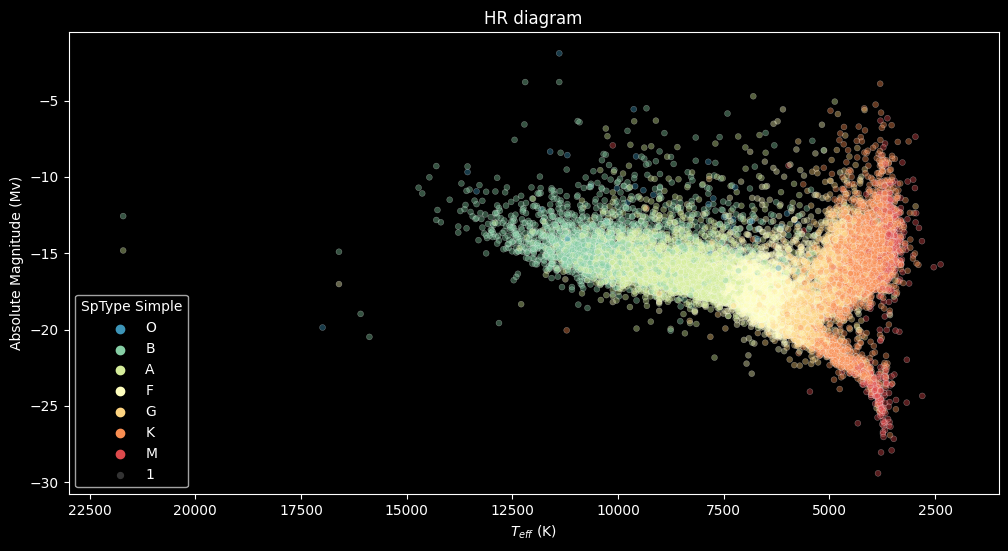

In [487]:
hr_sample = df.sample(n=int(length/5), replace=False) # take sample
plt.style.use("dark_background")
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'temp_K', y = 'M', data = hr_sample, hue = 'SpType Simple', hue_order = sp_types, palette = pal7, size = 1, alpha=0.4)
plt.xlim(23000, 1000)
plt.title("HR diagram")
plt.xlabel(r"$T_{eff}$ (K)")
plt.ylabel(r"Absolute Magnitude (Mv)")

## Heatmap

<Axes: >

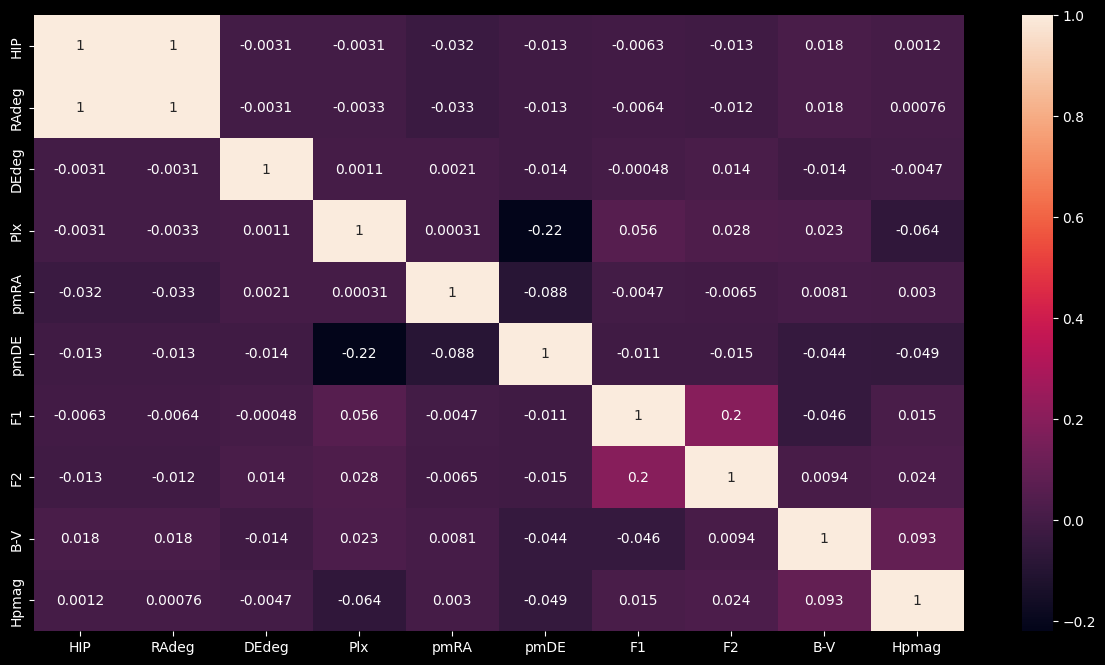

In [488]:
# Select only columns of interest
columns = ['HIP', 'RAdeg', 'DEdeg', 'Plx', 'pmRA', 'pmDE', 'F1', 'F2', 'B-V', 'Hpmag', 'SpType']

hm = data[columns]

# Select only numerical columns in dataframe:
hm = hm.select_dtypes(include=[np.number])

# Drop rows that have missing data (they account for <5% of the data)
hm.dropna(axis=0, inplace = True)

plt.figure(figsize=(15,8))
sns.heatmap(hm.corr(), annot = True)

## Star map

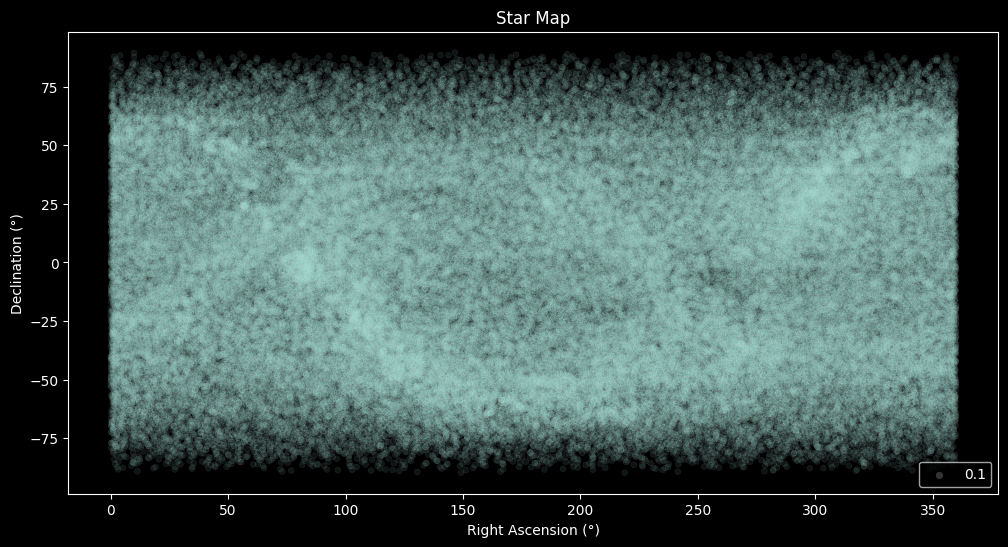

In [489]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'RAdeg', y = 'DEdeg', data = df, alpha=0.1, size=0.1)
plt.xlabel('Right Ascension (°)')
plt.ylabel('Declination (°)')
plt.title("Star Map")
plt.show()

## Proper Motion

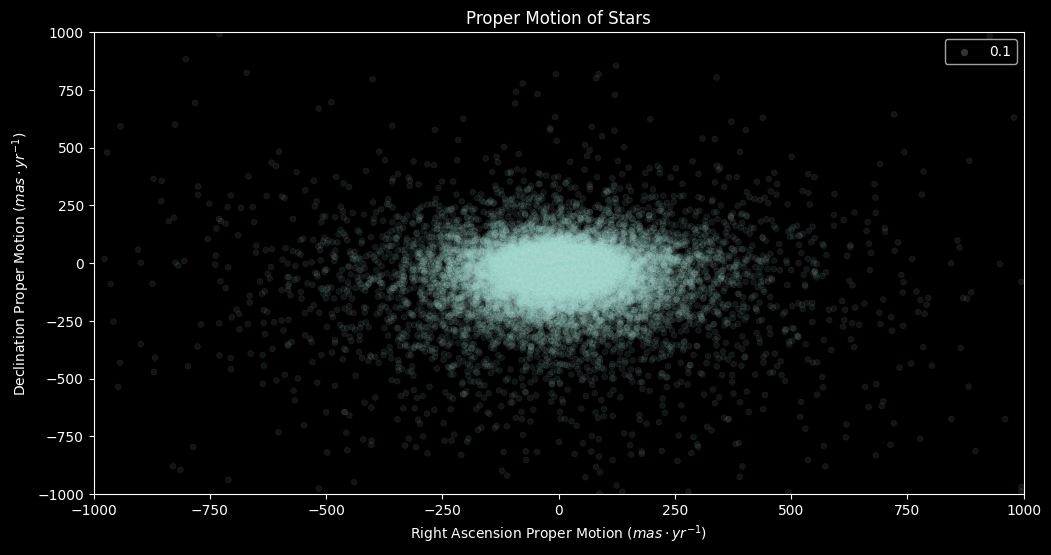

In [490]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'pmRA', y = 'pmDE', data = df, alpha=0.1, size=0.1)
plt.xlabel(r'Right Ascension Proper Motion $(mas \cdot yr^{-1})$')
plt.ylabel(r'Declination Proper Motion $(mas \cdot yr^{-1})$')
plt.title("Proper Motion of Stars")
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.show()

## Magnitude and Parallax Relplot

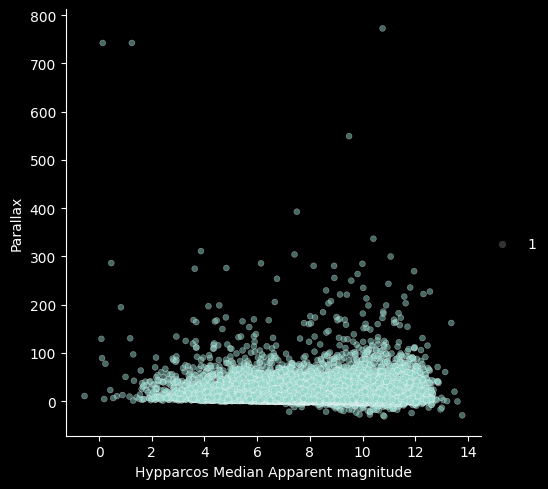

In [491]:
sns.relplot(data = hm, x = 'Hpmag', y = 'Plx', size = 1, alpha = 0.5)
plt.xlabel("Hypparcos Median Apparent magnitude")
plt.ylabel("Parallax")
plt.show()

## Distribution of Hpmag

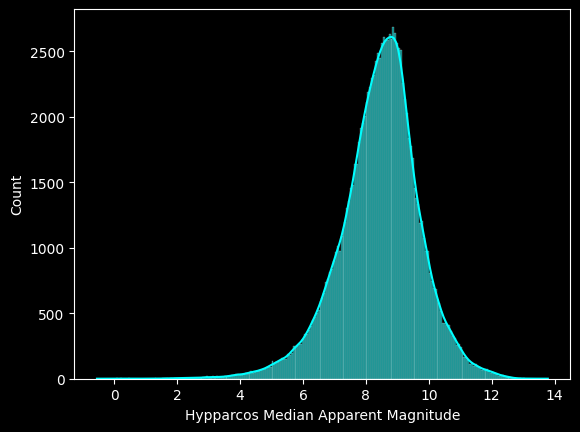

In [492]:
sns.histplot(data = hm, x = 'Hpmag', kde = True, color = 'cyan')
plt.xlabel("Hypparcos Median Apparent Magnitude")
plt.show()

## Distribution of Parallax

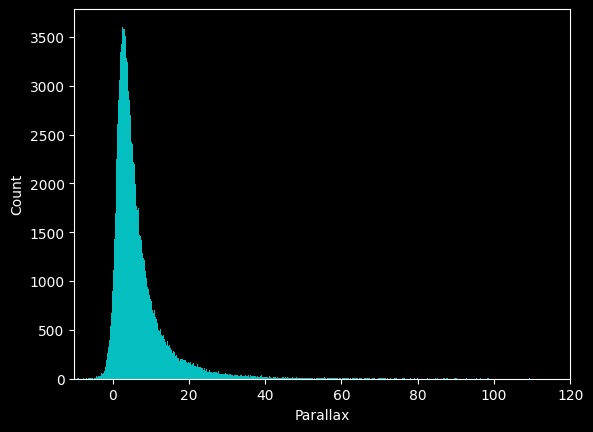

In [493]:
sns.histplot(data = hm, x = 'Plx', color = 'cyan')
plt.xlim(-10,120)
plt.xlabel("Parallax")
plt.show()

## Distribution of spectral types

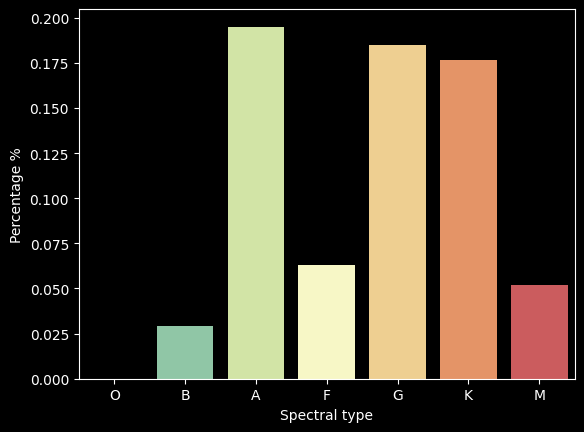

In [494]:
spTypePct = df['SpType'].value_counts(normalize = True) * 100
sns.barplot(x = spTypePct.index, y = spTypePct.values, palette = pal7, order = ['O','B','A','F','G','K','M'])
plt.xlabel("Spectral type")
plt.ylabel("Percentage %")
plt.show()

## Errors

### Relationship between errors and distance
Computing relationship between distance and errors in Parallax, Right Ascension, Declination, Right Ascension Proper Motio and Declination Proper Motion.
Because the measurements are not proportional with distance (there are more measurements of less distant stars), we will get the median errors for many intervals of distance.

In [495]:
errors = df[['dist_pc','e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE']]
errors.sort_values('dist_pc')

,dist_pc,e_RAdeg,e_DEdeg,e_Plx,e_pmRA,e_pmDE
70826,0.001295,1.31,1.51,2.42,1.52,1.82
71618,0.001347,1.42,1.08,1.40,1.51,1.24
71615,0.001347,46.20,36.28,1.40,26.10,19.75
53993,0.002548,0.67,0.59,0.91,0.77,0.77
92317,0.002972,1.72,0.92,1.82,2.22,1.45
...,...,...,...,...,...,...
2773,100.000000,1.23,0.85,1.41,1.64,1.01
74743,100.000000,0.73,0.57,0.99,0.80,0.76
62181,100.000000,1.12,0.95,1.34,1.20,0.81
96926,100.000000,1.10,0.56,1.26,1.40,0.54


In [496]:
error_medians_dict = {'distance':[], 'e_Plx':[], 'e_RAdeg':[], 'e_DEdeg':[], 'e_pmRA':[], 'e_pmDE':[]}
for distance in range(1,101,1): # between 1 and 100 pc
    group = errors[(errors['dist_pc'] >= (distance - 1)) & (errors['dist_pc'] < distance)]
    if len(group) > 0:
        error_medians_dict['distance'].append(distance)
        error_medians_dict['e_Plx'].append(np.nanmedian(group['e_Plx']))
        error_medians_dict['e_RAdeg'].append(np.nanmedian(group['e_RAdeg']))
        error_medians_dict['e_DEdeg'].append(np.nanmedian(group['e_DEdeg']))
        error_medians_dict['e_pmRA'].append(np.nanmedian(group['e_pmRA']))
        error_medians_dict['e_pmDE'].append(np.nanmedian(group['e_pmDE']))

error_medians = pd.DataFrame(data = error_medians_dict)
error_medians.set_index('distance', inplace = True)

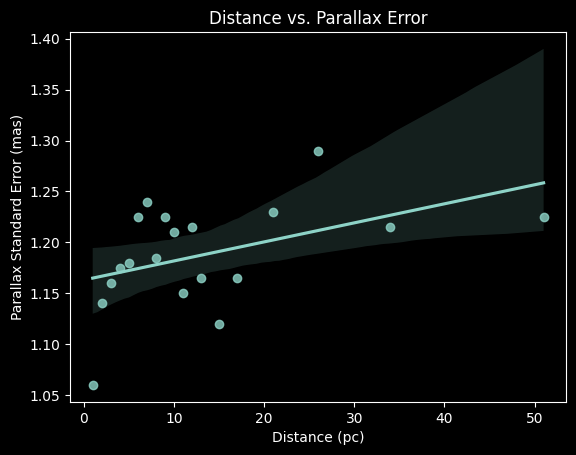

In [497]:
sns.regplot(x = error_medians.index, y = 'e_Plx', data = error_medians)
plt.title("Distance vs. Parallax Error")
plt.xlabel("Distance (pc)")
plt.ylabel("Parallax Standard Error (mas)")
plt.show()

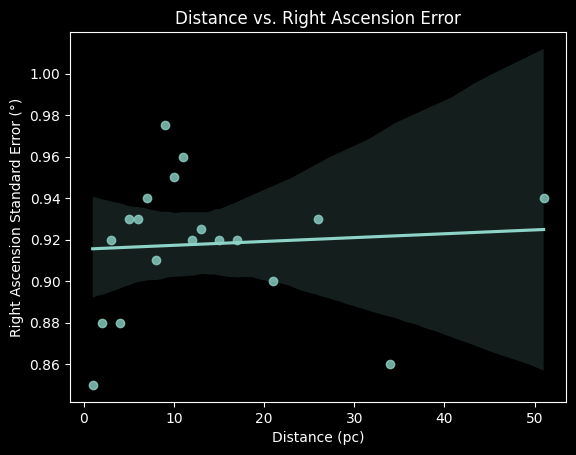

In [498]:
sns.regplot(x = error_medians.index, y = 'e_RAdeg', data = error_medians)
plt.title("Distance vs. Right Ascension Error")
plt.xlabel("Distance (pc)")
plt.ylabel("Right Ascension Standard Error (°)")
plt.show()

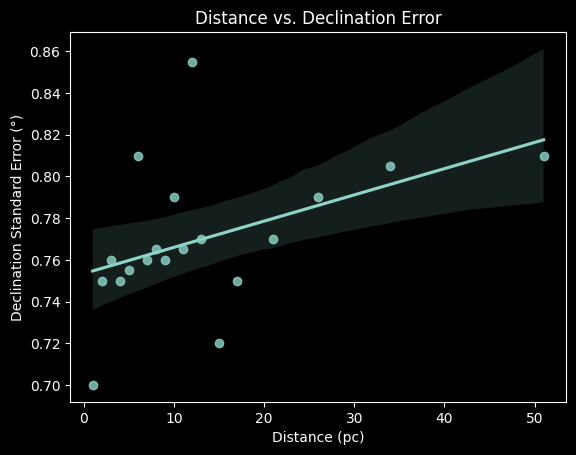

In [499]:
sns.regplot(x = error_medians.index, y = 'e_DEdeg', data = error_medians)
plt.title("Distance vs. Declination Error")
plt.xlabel("Distance (pc)")
plt.ylabel("Declination Standard Error (°)")
plt.show()

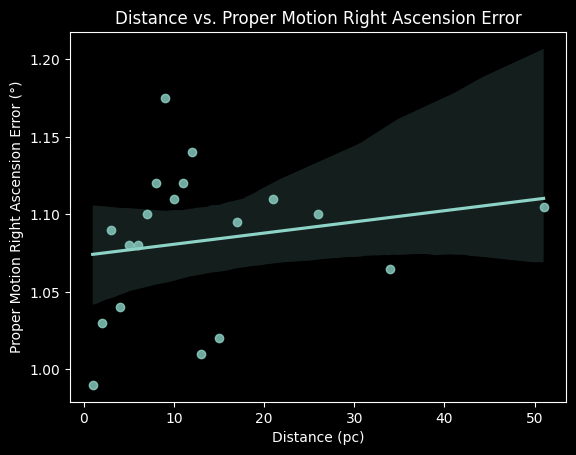

In [500]:
sns.regplot(x = error_medians.index, y = 'e_pmRA', data = error_medians)
plt.title("Distance vs. Proper Motion Right Ascension Error")
plt.xlabel("Distance (pc)")
plt.ylabel("Proper Motion Right Ascension Error (°)")
plt.show()

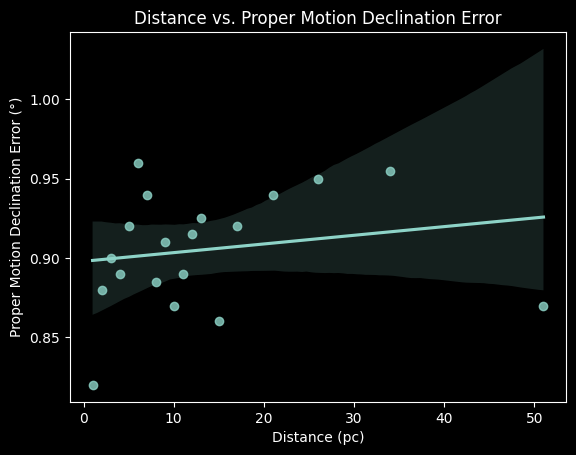

In [501]:
sns.regplot(x = error_medians.index, y = 'e_pmDE', data = error_medians)
plt.title("Distance vs. Proper Motion Declination Error")
plt.xlabel("Distance (pc)")
plt.ylabel("Proper Motion Declination Error (°)")
plt.show()

### Relationship between errors and magnitude
Exploring the relationship between magnitude (Hpmag) and the errors in Parallax, Right Ascension, Declination, Right Ascension Proper Motio and Declination Proper Motion. We follow the same procedure as with distance.

In [502]:
errors = df[['Hpmag','e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE']]
errors.sort_values('Hpmag')

,Hpmag,e_RAdeg,e_DEdeg,e_Plx,e_pmRA,e_pmDE
30416,-0.5536,0.50,0.46,0.53,0.53,0.56
91179,0.0868,0.48,0.47,0.55,0.57,0.60
69609,0.1114,0.92,0.42,0.74,0.60,0.52
71618,0.1373,1.42,1.08,1.40,1.51,1.24
24418,0.1930,0.65,0.48,0.81,0.74,0.53
...,...,...,...,...,...,...
190,12.6970,3.52,2.61,4.38,4.88,3.92
44229,12.7047,5.26,3.18,6.57,7.56,3.12
103815,12.8520,3.24,3.07,5.16,3.91,3.27
116952,13.1385,19.77,12.09,11.58,25.13,13.77


In [503]:
error_medians_dict = {'Hpmag':[], 'e_Plx':[], 'e_RAdeg':[], 'e_DEdeg':[], 'e_pmRA':[], 'e_pmDE':[]}
for mag in range(-2,14,1): # between -2 and 14 mag
    group = errors[(errors['Hpmag'] >= (mag - 1)) & (errors['Hpmag'] < mag)]
    if len(group) > 0:
        error_medians_dict['Hpmag'].append(mag)
        error_medians_dict['e_Plx'].append(np.nanmedian(group['e_Plx']))
        error_medians_dict['e_RAdeg'].append(np.nanmedian(group['e_RAdeg']))
        error_medians_dict['e_DEdeg'].append(np.nanmedian(group['e_DEdeg']))
        error_medians_dict['e_pmRA'].append(np.nanmedian(group['e_pmRA']))
        error_medians_dict['e_pmDE'].append(np.nanmedian(group['e_pmDE']))

error_medians = pd.DataFrame(data = error_medians_dict)
error_medians.set_index('Hpmag', inplace = True)

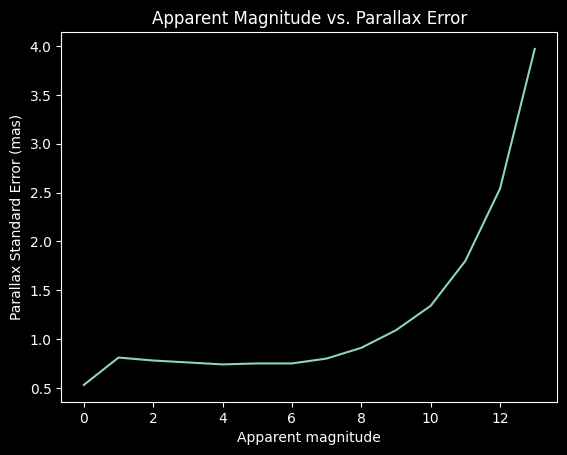

In [504]:
sns.lineplot(x = error_medians.index, y = 'e_Plx', data = error_medians)
plt.title("Apparent Magnitude vs. Parallax Error")
plt.xlabel("Apparent magnitude")
plt.ylabel("Parallax Standard Error (mas)")
plt.show()

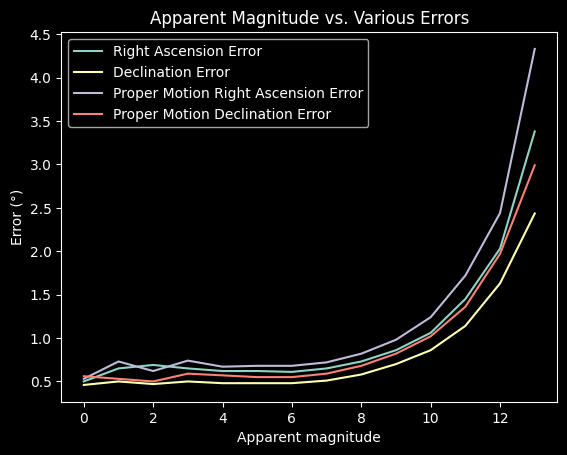

In [505]:
sns.lineplot(x = error_medians.index, y = 'e_RAdeg', data = error_medians, label = "Right Ascension Error")
sns.lineplot(x = error_medians.index, y = 'e_DEdeg', data = error_medians, label = "Declination Error")
sns.lineplot(x = error_medians.index, y = 'e_pmRA', data = error_medians, label = "Proper Motion Right Ascension Error")
sns.lineplot(x = error_medians.index, y = 'e_pmDE', data = error_medians, label = "Proper Motion Declination Error")
plt.title("Apparent Magnitude vs. Various Errors")
plt.xlabel("Apparent magnitude")
plt.ylabel("Error (°)")
plt.legend()
plt.show()

# Preprocessing
We only want to train the model for spectral types that appear a significant amount of times (~500 or more). We also want to use the rejection percentage (F1) and quality-of-fit (F2) columns to filter for reliable data only.

In [506]:
# F1 and F2 filtering
prev_len = len(df)
df = df[(df['F1'] < 3) & (df['F2'] > -2) & (df['F2'] < 2)]

In [ ]:
counts = df['SpType'].value_counts()
mask = df['SpType'].isin(counts[counts > 500].index)
df = df[mask]
print("Percentage of data after preprocessing:", 100*len(df)/prev_len, "%")

# Classification Model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier

# Define features and target
X = df[['temp_K','Plx','B-V','M']]
y = df['SpType']

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, random_state = SEED)
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # train-test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit model, make predictions
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # get probabilities for each class
    y_pred_probs = rf.predict_proba(X_test)
    
    # get roc curve for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(rf.n_classes_):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_pred_probs[:,i], pos_label = rf.classes_[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    total_roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class = 'ovr')
    
    # plot ROC curve for each class
    plt.figure(figsize=(12,8))
    for i in range(rf.n_classes_):
        plt.plot(fpr[i], tpr[i], label = "{} (AUC: {:.3f})".format(rf.classes_[i], roc_auc[i]))
    plt.text(0.4, 0.05, 'AUC: {:.3f}'.format(total_roc_auc), fontsize=14, color='cyan')
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Fold {}'.format(fold+1))
    plt.legend(loc='lower right', fontsize=7)
    plt.show()
    
    # visualising feature importance
    importances_rf = pd.Series(rf.feature_importances_, index = ['temp_K','Plx','B-V','M'])
    sorted_importances = importances_rf.sort_values()
    plt.figure(figsize=(4,4))
    sorted_importances.plot(kind = 'barh')
    plt.title("Feature Importance: Fold {}".format(fold+1))
    plt.show()